# Getting Started with the AρρEEARS API: Submitting and Downloading an Area Request
### This tutorial demonstrates how to use Python to connect to the AρρEEARS API 
The Application for Extracting and Exploring Analysis Ready Samples ([AρρEEARS](https://appeears.earthdatacloud.nasa.gov/)) offers a simple and efficient way to access and transform geospatial data from a variety of federal data archives in an easy-to-use web application interface. AρρEEARS enables users to subset [geospatial data](https://appeears.earthdatacloud.nasa.gov/products) spatially, temporally, and by band/layer for point and area samples. AρρEEARS returns not only the requested data, but also the associated quality values, and offers interactive visualizations with summary statistics in the web interface.  The [AρρEEARS API](https://appeears.earthdatacloud.nasa.gov/api/) offers users **programmatic access** to all features available in AρρEEARS, with the exception of visualizations. The API features are demonstrated in this notebook.  
***
### Example: Submit an area request using a U.S. National Park boundary as the region of interest for extracting elevation, vegetation and land surface temperature data    
Connect to the AρρEEARS API, query the list of available products, submit an area sample request, download the request, become familiar with the AρρEEARS Quality API, and import the results into Python for visualization. AρρEEARS area sample requests allow users to subset their desired data by spatial area via vector polygons (shapefiles or GeoJSONs). Users can also reproject and reformat the output data. AρρEEARS returns the valid data from the parameters defined within the sample request.       
#### Data Used in the Example:
- Data layers: 
    - NASA MEaSUREs Shuttle Radar Topography Mission (SRTM) Version 3 Digital Elevation Model  
        - [SRTMGL1_NC.003](https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003), 30m, static: 'SRTM_DEM' 
    - Combined MODIS Leaf Area Index (LAI)  
        - [MCD15A3H.006](https://doi.org/10.5067/MODIS/MCD15A3H.006), 500m, 4 day: 'Lai_500m'      
    - Terra MODIS Land Surface Temperature    
        - [MOD11A2.061](https://doi.org/10.5067/MODIS/MOD11A2.061), 1000m, 8 day: 'LST_Day_1km', 'LST_Night_1km'     
***  
# Topics Covered:
1. **Getting Started**  
    1a. Set Up the Working Environment  
    1b. Login [Login]     
2. **Query Available Products [Product API]**  
    2a. Search and Explore Available Products [List Products]  
    2b. Search and Explore Available Layers [List Layers]      
3. **Submit an Area Request [Tasks]**  
    3a. Import a Shapefile  
    3b. Search and Explore Available Projections [Spatial API]   
    3c. Compile a JSON [Task Object]  
    3d. Submit a Task Request [Submit Task]  
    3e. Retrieve Task Status [Retrieve Task]  
4. **Download a Request [Bundle API]**    
    4a. Explore Files in Request Output [List Files]    
    4b. Download Files in a Request (Automation) [Download File]   
5. **Explore AρρEEARS Quality Service [Quality API]**  
    5a. List Quality Layers [List Quality Layers]    
    5b. Show Quality Values [List Quality Values]   
    5c. Decode Quality Values [Decode Quality Values]  
6. **BONUS: Import Request Output and Visualize**    
    6a. Import a GeoTIFF     
    6b. Plot a GeoTIFF   
***
### Dependencies:
- This tutorial was tested using Python 3.6.1.  
- A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to complete this tutorial. You can create an account at the link provided.    
- To execute section 6, the [Geospatial Data Abstraction Library](http://www.gdal.org/) (GDAL) is required. 
***
### AρρEEARS Information:
To access AρρEEARS, visit: https://appeears.earthdatacloud.nasa.gov/  
> For comprehensive documentation of the full functionality of the AρρEEARS API, please see the AρρEEARS [API Documentation](https://appeears.earthdatacloud.nasa.gov/api/) 

Throughout the tutorial, specific sections of the API documentation can be accessed by clicking on the bracketed [] links in the section headings.   
***
### Files Used in this Tutorial:  
- [Administrative Boundaries of National Park System Units 12/31/2017 - National Geospatial Data Asset (NGDA) NPS National Parks Dataset](https://irma.nps.gov/DataStore/DownloadFile/594958)  

### Source Code used to Generate this Tutorial:
- [Jupyter Notebook](https://git.earthdata.nasa.gov/projects/LPDUR/repos/appeears-api-getting-started/browse/AppEEARS_API_Area.ipynb) 

***

# 1. Getting Started

***
## 1a. Set Up the Working Environment
#### Import the required packages, set the input/working directory, and create an output directory for the results.

In [1]:
# Import packages 
import requests as r
import getpass, pprint, time, os, cgi, json
import geopandas as gpd

ModuleNotFoundError: No module named 'requests'

#### If you are missing any of the packages above, download them in order to use the full functionality of this tutorial. 

In [ ]:
# Set input directory, change working directory
inDir = 'D:/appeears-api-getting-started/'           # IMPORTANT: Update to reflect directory on your OS
os.chdir(inDir)                                      # Change to working directory
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable

<div class="alert alert-block alert-warning" >
<b>If you plan to execute this tutorial on your own OS, `inDir` above needs to be changed.</b>
</div> 

***
## 1b. Login[[Login](https://appeears.earthdatacloud.nasa.gov/api/#login)] 
#### To submit a request, you must first login to the AρρEEARS API. The AρρEEARS API requires the same [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) as the AρρEEARS user interface. Use the `getpass` package to enter your NASA Earthdata login **Username** and **Password**. When prompted after executing the code block below, enter your username followed by your password.

In [ ]:
user = getpass.getpass(prompt = 'Enter NASA Earthdata Login Username: ')      # Input NASA Earthdata Login Username
password = getpass.getpass(prompt = 'Enter NASA Earthdata Login Password: ')  # Input NASA Earthdata Login Password

Enter NASA Earthdata Login Username: ········
Enter NASA Earthdata Login Password: ········


#### Use the `requests` package to post your username and password. A successful login will provide you with a token to be used later in this tutorial to submit a request. For more information or if you are experiencing difficulties, please see the [API Documentation](https://lpdaacsvc.cr.usgs.gov/appeears/api/?language=Python%203#login).

In [ ]:
token_response = r.post('{}login'.format(api), auth=(user, password)).json() # Insert API URL, call login service, provide credentials & return json
del user, password                                                           # Remove user and password information
token_response                                                               # Print response

{'token_type': 'Bearer',
 'token': 'ecXFFASPIWu_ESd_8B429AZCBFsPLXuOo8M9kCC8Jcqait7AiSQXh4-WGYhwJqaePqPVPhw5FbADMiVYOxM_vA',
 'expiration': '2022-05-06T19:29:39Z'}

{'token_type': 'Bearer',
 'token': 'ecXFFASPIWu_ESd_8B429AZCBFsPLXuOo8M9kCC8Jcqait7AiSQXh4-WGYhwJqaePqPVPhw5FbADMiVYOxM_vA',
 'expiration': '2022-05-06T19:29:39Z'}

#### Above, you should see a Bearer token. Notice that this token will expire approximately 48 hours after being acquired. 
***
# 2. Query Available Products [[Product API](https://appeears.earthdatacloud.nasa.gov/api/#product)]
## 2a. Search and Explore Available Products [[List Products](https://appeears.earthdatacloud.nasa.gov/api/#list-products)]
#### The product API provides details about all of the products and layers available in AρρEEARS. Below, call the product API to list all of the products available in AρρEEARS.

In [ ]:
product_response = r.get('{}product'.format(api)).json()                         # request all products in the product service
print('AρρEEARS currently supports {} products.'.format(len(product_response)))  # Print no. products available in AppEEARS

AρρEEARS currently supports 155 products.
AρρEEARS currently supports 155 products.


#### Next, create a dictionary indexed by product name, making it easier to query a specific product.

In [ ]:
products = {p['ProductAndVersion']: p for p in product_response} # Create a dictionary indexed by product name & version
products['MCD15A3H.006']                                         # Print information for MCD15A3H.006 LAI/FPAR Product

{'Product': 'MCD15A3H',
 'Platform': 'Combined MODIS',
 'Description': 'Leaf Area Index (LAI) and Fraction of Photosynthetically Active Radiation (FPAR)',
 'RasterType': 'Tile',
 'Resolution': '500m',
 'TemporalGranularity': '4 day',
 'Version': '006',
 'Available': True,
 'DocLink': 'https://doi.org/10.5067/MODIS/MCD15A3H.006',
 'Source': 'LP DAAC',
 'TemporalExtentStart': '2002-07-04',
 'TemporalExtentEnd': 'Present',
 'Deleted': False,
 'DOI': '10.5067/MODIS/MCD15A3H.006',
 'ProductAndVersion': 'MCD15A3H.006'}

{'Product': 'MCD15A3H',
 'Platform': 'Combined MODIS',
 'Description': 'Leaf Area Index (LAI) and Fraction of Photosynthetically Active Radiation (FPAR)',
 'RasterType': 'Tile',
 'Resolution': '500m',
 'TemporalGranularity': '4 day',
 'Version': '006',
 'Available': True,
 'DocLink': 'https://doi.org/10.5067/MODIS/MCD15A3H.006',
 'Source': 'LP DAAC',
 'TemporalExtentStart': '2002-07-04',
 'TemporalExtentEnd': 'Present',
 'Deleted': False,
 'DOI': '10.5067/MODIS/MCD15A3H.006',
 'ProductAndVersion': 'MCD15A3H.006'}

#### The product service provides many useful details, including if a product is currently available in AρρEEARS, a description, and information on the spatial and temporal resolution. 

#### Below, make a list of all product+version names, and search for products containing *Leaf Area Index* in their description. 

In [ ]:
prodNames = {p['ProductAndVersion'] for p in product_response} # Make list of all products (including version)
for p in prodNames:                                            # Make for loop to search list of products 'Description' for a keyword                
    if 'Leaf Area Index' in products[p]['Description']:
        pprint.pprint(products[p])                             # Print info for each product containing LAI in its description

{'Available': True,
 'DOI': '10.5067/MODIS/MCD15A3H.006',
 'Deleted': False,
 'Description': 'Leaf Area Index (LAI) and Fraction of Photosynthetically '
                'Active Radiation (FPAR)',
 'DocLink': 'https://doi.org/10.5067/MODIS/MCD15A3H.006',
 'Platform': 'Combined MODIS',
 'Product': 'MCD15A3H',
 'ProductAndVersion': 'MCD15A3H.006',
 'RasterType': 'Tile',
 'Resolution': '500m',
 'Source': 'LP DAAC',
 'TemporalExtentEnd': 'Present',
 'TemporalExtentStart': '2002-07-04',
 'TemporalGranularity': '4 day',
 'Version': '006'}
{'Available': True,
 'DOI': '10.5067/MODIS/MYD15A2H.061',
 'Deleted': False,
 'Description': 'Leaf Area Index (LAI) and Fraction of Photosynthetically '
                'Active Radiation (FPAR)',
 'DocLink': 'https://doi.org/10.5067/MODIS/MYD15A2H.061',
 'Platform': 'Aqua MODIS',
 'Product': 'MYD15A2H',
 'ProductAndVersion': 'MYD15A2H.061',
 'RasterType': 'Tile',
 'Resolution': '500m',
 'Source': 'LP DAAC',
 'TemporalExtentEnd': 'Present',
 'TemporalExtentSt

#### Using the info above, start a list of desired products by using the highest temporal resolution LAI product, `MCD15A3H.006`.  

In [ ]:
prods = ['MCD15A3H.006']     # Start a list for products to be requested, beginning with MCD15A3H.006
prods.append('MOD11A2.061')  # Append the MOD11A2.061 8 day LST product to the list of products desired
prods.append('SRTMGL1_NC.003')  # Append the SRTMGL1_NC.003 product to the list of products desired
prods                        # Print list

['MCD15A3H.006', 'MOD11A2.061', 'SRTMGL1_NC.003']

['MCD15A3H.006', 'MOD11A2.061', 'SRTMGL1_NC.003']

***
# 2b. Search and Explore Available Layers [[List Layers](https://appeears.earthdatacloud.nasa.gov/api/#list-layers)]
#### The product API allows you to call all of the layers available for a given product. Each product is referenced by its `ProductAndVersion` property. For a list of the layer names only, print the keys from the dictionary below. 

In [ ]:
lst_response = r.get('{}product/{}'.format(api, prods[1])).json()  # Request layers for the 2nd product (index 1) in the list: MOD11A2.061
list(lst_response.keys())

['Clear_sky_days',
 'Clear_sky_nights',
 'Day_view_angl',
 'Day_view_time',
 'Emis_31',
 'Emis_32',
 'LST_Day_1km',
 'LST_Night_1km',
 'Night_view_angl',
 'Night_view_time',
 'QC_Day',
 'QC_Night']

['Clear_sky_days',
 'Clear_sky_nights',
 'Day_view_angl',
 'Day_view_time',
 'Emis_31',
 'Emis_32',
 'LST_Day_1km',
 'LST_Night_1km',
 'Night_view_angl',
 'Night_view_time',
 'QC_Day',
 'QC_Night']

#### Use the dictionary key `'LST_Day_1km'` to see the information for that layer in the response.

In [ ]:
lst_response['LST_Day_1km'] # Print layer response

{'AddOffset': 0.0,
 'Available': True,
 'DataType': 'float32',
 'Description': 'Day Land Surface Temperature',
 'Dimensions': ['time', 'YDim', 'XDim'],
 'FillValue': 0,
 'IsQA': False,
 'Layer': 'LST_Day_1km',
 'OrigDataType': 'uint16',
 'OrigValidMax': 65535,
 'OrigValidMin': 7500,
 'QualityLayers': "['QC_Day']",
 'QualityProductAndVersion': 'MOD11A2.061',
 'ScaleFactor': 0.02,
 'Units': 'Kelvin',
 'ValidMax': 1310.699951,
 'ValidMin': 150.0,
 'XSize': 1200,
 'YSize': 1200}

{'AddOffset': 0.0,
 'Available': True,
 'DataType': 'float32',
 'Description': 'Day Land Surface Temperature',
 'Dimensions': ['time', 'YDim', 'XDim'],
 'FillValue': 0,
 'IsQA': False,
 'Layer': 'LST_Day_1km',
 'OrigDataType': 'uint16',
 'OrigValidMax': 65535,
 'OrigValidMin': 7500,
 'QualityLayers': "['QC_Day']",
 'QualityProductAndVersion': 'MOD11A2.061',
 'ScaleFactor': 0.02,
 'Units': 'Kelvin',
 'ValidMax': 1310.699951,
 'ValidMin': 150.0,
 'XSize': 1200,
 'YSize': 1200}

#### AρρEEARS also allows subsetting data spectrally (by band). Create a tupled list with product name and specific layers desired. 

In [ ]:
layers = [(prods[1],'LST_Day_1km'),(prods[1],'LST_Night_1km')]  # Create tupled list linking desired product with desired layers

#### Next, request the layers for the `MCD15A3H.006` product.

In [ ]:
lai_response = r.get('{}product/{}'.format(api, prods[0])).json()  # Request layers for the 1st product (index 0) in the list: MCD15A3H.006
list(lai_response.keys())                                          # Print the LAI layer names

['FparExtra_QC',
 'FparLai_QC',
 'FparStdDev_500m',
 'Fpar_500m',
 'LaiStdDev_500m',
 'Lai_500m']

['FparExtra_QC',
 'FparLai_QC',
 'FparStdDev_500m',
 'Fpar_500m',
 'LaiStdDev_500m',
 'Lai_500m']

In [ ]:
lai_response['Lai_500m']['Description']  # Make sure the correct layer is requested

'Leaf area index'

'Leaf area index'

#### Above, `Lai_500m` is the desired layer within the `MCD15A3h.006` product. 
#### Next, append `Lai_500m` to the tupled list of desired product/layers. 

In [ ]:
layers.append((prods[0],'Lai_500m')) # Append to tupled list linking desired product with desired layers

#### Thirdly, request the layers for the `SRTMGL1_NC.003` product.

In [ ]:
dem_response = r.get('{}product/{}'.format(api, prods[2])).json()  # Request layers for the 3rd product (index 2) in the list: SRTMGL1_NC.003
list(dem_response.keys())                                          # Print the SRTM DEM layer names 

['SRTMGL1_DEM']

['SRTMGL1_DEM']

#### Finally, append `SRTMGL1_DEM` to the tupled list of desired products/layers.

In [ ]:
layers.append((prods[2], 'SRTMGL1_DEM')) # Append to tupled list linking desired product with desired layers

#### Below, take the tupled list (layers) and create a list of dictionaries to store each layer+product combination. This will make it easier to insert into the json file used to submit a request in Section 3. 

In [ ]:
prodLayer = []
for l in layers:
    prodLayer.append({
            "layer": l[1],
            "product": l[0]
          })
prodLayer

[{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
 {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
 {'layer': 'Lai_500m', 'product': 'MCD15A3H.006'},
 {'layer': 'SRTMGL1_DEM', 'product': 'SRTMGL1_NC.003'}]

[{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
 {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
 {'layer': 'Lai_500m', 'product': 'MCD15A3H.006'},
 {'layer': 'SRTMGL1_DEM', 'product': 'SRTMGL1_NC.003'}]

***
# 3. Submit an Area Request [[Tasks](https://appeears.earthdatacloud.nasa.gov/api/#tasks)]
#### The **Submit task** API call provides a way to submit a new request to be processed. It can accept data via JSON, query string, or a combination of both. In the example below, compile a json and submit a request. Tasks in AρρEEARS correspond to each request associated with your user account. Therefore, each of the calls to this service requires an authentication token (see Section 1c.), which is stored in a header below. 

In [ ]:
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

---
## 3a. Import a Shapefile
#### In this section, begin by importing a shapefile using the `geopandas` package. The shapefile is publically available for download from the [NPS website](https://irma.nps.gov/DataStore/Reference/Profile/2224545?lnv=True).

In [ ]:
nps = gpd.read_file('{}nps_boundary.shp'.format(inDir + os.sep + 'Data' + os.sep)) # Read in shapefile as dataframe using geopandas
print(nps.head())                                                # Print first few lines of dataframe

  UNIT_CODE                                          GIS_Notes  \
0      AMME  LEGACY: contact allen_mccoy@nps.gov for additi...   
1      EBLA  LEGACY: contact allen_mccoy@nps.gov for additi...   
2      LARO  LEGACY: contact allen_mccoy@nps.gov for additi...   
3      LEWI  LEGACY: contact allen_mccoy@nps.gov for additi...   
4      OLYM  LEGACY: contact allen_mccoy@nps.gov for additi...   

                                    UNIT_NAME   DATE_EDIT STATE REGION  \
0                      American Memorial Park  2015-04-22    MP     PW   
1  Ebey's Landing National Historical Reserve  2015-04-22    WA     PW   
2     Lake Roosevelt National Recreation Area  2015-04-22    WA     PW   
3    Lewis and Clark National Historical Park  2015-04-22    WA     PW   
4                       Olympic National Park  2015-04-22    WA     PW   

   GNIS_ID                    UNIT_TYPE CREATED_BY METADATA  \
0  1879026                         Park     Legacy     None   
1  1888910  National Historical 

#### Below, query the `geopandas` dataframe for the national park that you are interested in using for your region of interest, here *Grand Canyon National Park*.

In [ ]:
nps_gc = nps[nps['UNIT_NAME']=='Grand Canyon National Park'].to_json() # Extract Grand Canyon NP and set to variable
nps_gc = json.loads(nps_gc)                                            # Convert to json format

---
## 3b. Search and Explore Available Projections [[Spatial API](https://appeears.earthdatacloud.nasa.gov/api/#spatial)]   
#### The spatial API provides some helper services used to support submitting area task requests. The call below will retrieve the list of supported projections in AρρEEARS.

In [ ]:
projections = r.get('{}spatial/proj'.format(api)).json()  # Call to spatial API, return projs as json
projections                                               # Print projections and information

[{'Name': 'native',
  'Description': 'Native Projection',
  'Platforms': '',
  'Proj4': '',
  'Datum': '',
  'EPSG': '',
  'Units': '',
  'GridMapping': '',
  'Available': True},
 {'Name': 'geographic',
  'Description': 'Geographic',
  'Platforms': "['SRTM', 'ECOSTRESS', 'SSEBop ET', 'GPW', 'ASTER GDEM', 'NASADEM']",
  'Proj4': '+proj=longlat +datum=WGS84 +no_defs',
  'Datum': 'wgs84',
  'EPSG': 4326.0,
  'Units': 'degrees',
  'GridMapping': 'latitude_longitude',
  'Available': True},
 {'Name': 'sinu_modis',
  'Description': 'MODIS Sinusoidal',
  'Platforms': "['Combined MODIS', 'Terra MODIS', 'Aqua MODIS', 'S-NPP NASA VIIRS', 'Global WELD']",
  'Proj4': '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +no_defs',
  'Datum': '',
  'EPSG': '',
  'Units': 'meters',
  'GridMapping': 'sinusoidal',
  'Available': True},
 {'Name': 'albers_weld_alaska',
  'Description': 'WELD Albers Equal Area Alaska',
  'Platforms': "['WELD']",
  'Proj4': '+proj=aea +lat_1=55 +lat_2=65 +lat_0=50 +lo

[{'Name': 'native',
  'Description': 'Native Projection',
  'Platforms': '',
  'Proj4': '',
  'Datum': '',
  'EPSG': '',
  'Units': '',
  'GridMapping': '',
  'Available': True},
 {'Name': 'geographic',
  'Description': 'Geographic',
  'Platforms': "['SRTM', 'ECOSTRESS', 'SSEBop ET', 'GPW', 'ASTER GDEM', 'NASADEM']",
  'Proj4': '+proj=longlat +datum=WGS84 +no_defs',
  'Datum': 'wgs84',
  'EPSG': 4326.0,
  'Units': 'degrees',
  'GridMapping': 'latitude_longitude',
  'Available': True},
 {'Name': 'sinu_modis',
  'Description': 'MODIS Sinusoidal',
  'Platforms': "['Combined MODIS', 'Terra MODIS', 'Aqua MODIS', 'S-NPP NASA VIIRS', 'Global WELD']",
  'Proj4': '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +no_defs',
  'Datum': '',
  'EPSG': '',
  'Units': 'meters',
  'GridMapping': 'sinusoidal',
  'Available': True},
 {'Name': 'albers_weld_alaska',
  'Description': 'WELD Albers Equal Area Alaska',
  'Platforms': "['WELD']",
  'Proj4': '+proj=aea +lat_1=55 +lat_2=65 +lat_0=50 +lo

#### Create a dictionary of projections with projection `Name` as the keys.

In [ ]:
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p  # Fill dictionary with `Name` as keys
list(projs.keys())                          # Print dictionary keys

['native',
 'geographic',
 'sinu_modis',
 'albers_weld_alaska',
 'albers_weld_conus',
 'albers_ard_alaska',
 'albers_ard_conus',
 'albers_ard_hawaii',
 'easegrid_2_global',
 'easegrid_2_north',
 'laea_sphere_19']

['native',
 'geographic',
 'sinu_modis',
 'albers_weld_alaska',
 'albers_weld_conus',
 'albers_ard_alaska',
 'albers_ard_conus',
 'albers_ard_hawaii',
 'easegrid_2_global',
 'easegrid_2_north',
 'laea_sphere_19']

#### Print the information for the projection used in this tutorial.

In [ ]:
projs['geographic']

{'Name': 'geographic',
 'Description': 'Geographic',
 'Platforms': "['SRTM', 'ECOSTRESS', 'SSEBop ET', 'GPW', 'ASTER GDEM', 'NASADEM']",
 'Proj4': '+proj=longlat +datum=WGS84 +no_defs',
 'Datum': 'wgs84',
 'EPSG': 4326.0,
 'Units': 'degrees',
 'GridMapping': 'latitude_longitude',
 'Available': True}

{'Name': 'geographic',
 'Description': 'Geographic',
 'Platforms': "['SRTM', 'ECOSTRESS', 'SSEBop ET', 'GPW', 'ASTER GDEM', 'NASADEM']",
 'Proj4': '+proj=longlat +datum=WGS84 +no_defs',
 'Datum': 'wgs84',
 'EPSG': 4326.0,
 'Units': 'degrees',
 'GridMapping': 'latitude_longitude',
 'Available': True}

---
## 3c. Compile a JSON  [[Task Object](https://appeears.earthdatacloud.nasa.gov/api/#task-object)]
#### In this section, begin by setting up the information needed to compile an acceptable json for submitting an AρρEEARS area request. For detailed information on required json parameters, see the [API Documentation](https://appeears.earthdatacloud.nasa.gov/api/). 

In [ ]:
task_name = input('Enter a Task Name: ') # User-defined name of the task: 'NPS Vegetation Area' used in example

Enter a Task Name: NPS Vegetation Area


In [ ]:
task_type = ['point','area']        # Type of task, area or point
proj = projs['geographic']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
startDate = '07-01-2017'            # Start of the date range for which to extract data: MM-DD-YYYY
endDate = '07-31-2017'              # End of the date range for which to extract data: MM-DD-YYYY
recurring = False                   # Specify True for a recurring date range
#yearRange = [2000,2016]            # if recurring = True, set yearRange, change start/end date to MM-DD

#### Below, compile the JSON to be submitted as an area request. Notice that `nps_gc` is inserted from the shapefile transformed to a json via the `geopandas` and `json` packages above in section 3a. 

In [ ]:
task = {
    'task_type': task_type[1],
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate
         }],
         'layers': prodLayer,
         'output': {
                 'format': {
                         'type': outFormat[0]}, 
                         'projection': proj},
         'geo': nps_gc,
    }
}

***
## 3d. Submit a Task Request [[Submit Task](https://appeears.earthdatacloud.nasa.gov/api/#submit-task)]
#### Below, post a call to the API task service, using the `task` json created above.

In [ ]:
task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to the API task service, return response as json
task_response                                                                 # Print task response

{'task_id': 'ede0d7c3-4887-4cdc-8f49-458008862aaf', 'status': 'pending'}

{'task_id': 'ede0d7c3-4887-4cdc-8f49-458008862aaf', 'status': 'pending'}

***
## 3e. Retrieve Task Status [[Retrieve Task](https://appeears.earthdatacloud.nasa.gov/api/#retrieve-task)]
#### This API call will list all of the requests associated with your user account, automatically sorted by date descending with the most recent requests listed first. 

#### The AρρEEARS API contains some helpful formatting resources. Below, limit the API response to 2 entries and set `pretty` to True to format the response as an organized json, making it easier to read. Additional information on AρρEEARS API [pagination](https://appeears.earthdatacloud.nasa.gov/api/#pagination) and [formatting](https://appeears.earthdatacloud.nasa.gov/api/#formatting) can be found in the API documentation. 

In [ ]:
params = {'limit': 2, 'pretty': True} # Limit API response to 2 most recent entries, return as pretty json

In [ ]:
tasks_response = r.get('{}task'.format(api), params=params, headers=head).json() # Query task service, setting params and header 
tasks_response                                                                   # Print tasks response

[{'params': {'dates': [{'endDate': '07-31-2017', 'startDate': '07-01-2017'}],
   'layers': [{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
    {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
    {'layer': 'Lai_500m', 'product': 'MCD15A3H.006'},
    {'layer': 'SRTMGL1_DEM', 'product': 'SRTMGL1_NC.003'}],
   'output': {'format': {'type': 'geotiff'}, 'projection': 'geographic'}},
  'status': 'pending',
  'created': '2022-05-06T18:21:00.769083',
  'task_id': 'ede0d7c3-4887-4cdc-8f49-458008862aaf',
  'updated': '2022-05-06T18:21:11.961486',
  'user_id': 'user@email.com',
  'estimate': {'request_size': 196969757.51610893},
  'has_swath': False,
  'task_name': 'NPS Vegetation Area',
  'task_type': 'area',
  'api_version': 'v1',
  'svc_version': '3.2.1',
  'web_version': None,
  'has_nsidc_daac': False,
  'expires_on': '2022-06-05T18:21:11.961486'},
 {'error': None,
  'params': {'dates': [{'endDate': '12-31-2017', 'startDate': '01-01-2017'}],
   'layers': [{'layer': 'LST_Day_1km', '

[{'params': {'dates': [{'endDate': '07-31-2017', 'startDate': '07-01-2017'}],
   'layers': [{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
    {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
    {'layer': 'Lai_500m', 'product': 'MCD15A3H.006'},
    {'layer': 'SRTMGL1_DEM', 'product': 'SRTMGL1_NC.003'}],
   'output': {'format': {'type': 'geotiff'}, 'projection': 'geographic'}},
  'status': 'pending',
  'created': '2022-05-06T18:21:00.769083',
  'task_id': 'ede0d7c3-4887-4cdc-8f49-458008862aaf',
  'updated': '2022-05-06T18:21:11.961486',
  'user_id': 'user@email.com',
  'estimate': {'request_size': 196969757.51610893},
  'has_swath': False,
  'task_name': 'NPS Vegetation Area',
  'task_type': 'area',
  'api_version': 'v1',
  'svc_version': '3.2.1',
  'web_version': None,
  'has_nsidc_daac': False,
  'expires_on': '2022-06-05T18:21:11.961486'},
 {'error': None,
  'params': {'dates': [{'endDate': '12-31-2017', 'startDate': '01-01-2017'}],
   'layers': [{'layer': 'LST_Day_1km', '

#### Next, take the task id returned from the `task_response` that was generated when submitting your request, and use the AρρEEARS API status service to check the status of your request.

In [ ]:
task_id = task_response['task_id']                                               # Set task id from request submission
status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials
status_response                                                        

{'task_id': 'ede0d7c3-4887-4cdc-8f49-458008862aaf',
 'status': 'pending',
 'user_id': 'user@email.com',
 'updated': '2022-05-06T18:21:11.961486',
 'status_type': 'task'}

{'task_id': 'ede0d7c3-4887-4cdc-8f49-458008862aaf',
 'status': 'pending',
 'user_id': 'user@email.com',
 'updated': '2022-05-06T18:21:11.961486',
 'status_type': 'task'}

#### Above, if your request is still processing, you can find information on the status of how close it is to completing. 
#### Below, call the task service for your request every 20 seconds to check the status of your request.

In [ ]:
# Ping API until request is complete, then continue to Section 4
starttime = time.time()
while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
    print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])

pending
pending
pending
pending
pending
pending
pending
pending
pending
pending
pending
pending
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
done
done


***
# 4. Download a Request [[Bundle API](https://appeears.earthdatacloud.nasa.gov/api/#bundle)]
#### Before downloading the request output, set up an output directory to store the output files, and examine the files contained in the request output. 

In [ ]:
destDir = os.path.join(inDir, task_name)                # Set up output directory using input directory and task name
if not os.path.exists(destDir):os.makedirs(destDir)     # Create the output directory

---
## 4a. Explore Files in Request Output [[List Files](https://appeears.earthdatacloud.nasa.gov/api/#list-files)]
#### The bundle API provides information about completed tasks. For any completed task, a bundle can be queried to return the files contained as a part of the task request. Below, call the bundle API and return all of the output files.

In [ ]:
bundle = r.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
bundle                                                    # Print bundle contents

{'files': [{'sha256': '9931687ff1bda429c6fe1b3bfaf67ea60ca82b118dd542c5447a271e933ac19e',
   'file_id': '883b2c91-674e-41eb-9868-bd0c66f2499b',
   'file_name': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017181_aid0001.tif',
   'file_size': 13516,
   'file_type': 'tif'},
  {'sha256': '184b3039d86523ea38a6df08a862dfa717694c03bca2c1e9526ae80dad9d2d77',
   'file_id': 'cca17927-2eb2-4f67-8c25-adffc970e33e',
   'file_name': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017185_aid0001.tif',
   'file_size': 13435,
   'file_type': 'tif'},
  {'sha256': '1e9e90105902a6a20fec619816ac85ef05b74e28c616f0be68f70d49baac4627',
   'file_id': '884a41ab-978b-46cb-8087-bf7ffc6c850c',
   'file_name': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017189_aid0001.tif',
   'file_size': 13713,
   'file_type': 'tif'},
  {'sha256': '0893f432bb8985e945993835d2e5d034a49216d298084c9b5be877280856457a',
   'file_id': '39fb9aad-7564-4925-a4fa-766e3b732163',
   'file_name': 'MCD15

{'files': [{'sha256': '9931687ff1bda429c6fe1b3bfaf67ea60ca82b118dd542c5447a271e933ac19e',
   'file_id': '883b2c91-674e-41eb-9868-bd0c66f2499b',
   'file_name': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017181_aid0001.tif',
   'file_size': 13516,
   'file_type': 'tif'},
  {'sha256': '184b3039d86523ea38a6df08a862dfa717694c03bca2c1e9526ae80dad9d2d77',
   'file_id': 'cca17927-2eb2-4f67-8c25-adffc970e33e',
   'file_name': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017185_aid0001.tif',
   'file_size': 13435,
   'file_type': 'tif'},
  {'sha256': '1e9e90105902a6a20fec619816ac85ef05b74e28c616f0be68f70d49baac4627',
   'file_id': '884a41ab-978b-46cb-8087-bf7ffc6c850c',
   'file_name': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017189_aid0001.tif',
   'file_size': 13713,
   'file_type': 'tif'},
  {'sha256': '0893f432bb8985e945993835d2e5d034a49216d298084c9b5be877280856457a',
   'file_id': '39fb9aad-7564-4925-a4fa-766e3b732163',
   'file_name': 'MCD15

***
## 4b. Download Files in a Request (Automation) [[Download File](https://appeears.earthdatacloud.nasa.gov/api/#download-file)]
#### Now, use the contents of the bundle to select the file name and id and store as a dictionary. 

In [ ]:
files = {}                                                       # Create empty dictionary
for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values
files    

{'883b2c91-674e-41eb-9868-bd0c66f2499b': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017181_aid0001.tif',
 'cca17927-2eb2-4f67-8c25-adffc970e33e': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017185_aid0001.tif',
 '884a41ab-978b-46cb-8087-bf7ffc6c850c': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017189_aid0001.tif',
 '39fb9aad-7564-4925-a4fa-766e3b732163': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017193_aid0001.tif',
 '15b09334-d519-4f99-b798-5929ee893c4b': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017197_aid0001.tif',
 'a7adc9dc-fc7b-46c7-8129-69acb2b65773': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017201_aid0001.tif',
 '828813ec-8bdc-46fd-aaa2-9edb2a05b4da': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017205_aid0001.tif',
 'c92e297e-c691-4275-a49b-aff597fb85ab': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017209_aid0001.tif',
 'b6bead40-be5c-42f0-9464-663ad3

{'883b2c91-674e-41eb-9868-bd0c66f2499b': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017181_aid0001.tif',
 'cca17927-2eb2-4f67-8c25-adffc970e33e': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017185_aid0001.tif',
 '884a41ab-978b-46cb-8087-bf7ffc6c850c': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017189_aid0001.tif',
 '39fb9aad-7564-4925-a4fa-766e3b732163': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017193_aid0001.tif',
 '15b09334-d519-4f99-b798-5929ee893c4b': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017197_aid0001.tif',
 'a7adc9dc-fc7b-46c7-8129-69acb2b65773': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017201_aid0001.tif',
 '828813ec-8bdc-46fd-aaa2-9edb2a05b4da': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017205_aid0001.tif',
 'c92e297e-c691-4275-a49b-aff597fb85ab': 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017209_aid0001.tif',
 'b6bead40-be5c-42f0-9464-663ad3

#### Use the `files` dictionary and a `for` loop to automate downloading all of the output files into the output directory. 

In [ ]:
for f in files:
    dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')                                # Get a stream to the bundle file
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f] 
    filepath = os.path.join(destDir, filename)                                                       # Create output file path
    with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
        for data in dl.iter_content(chunk_size=8192): f.write(data) 
print('Downloaded files can be found at: {}'.format(destDir))

Downloaded files can be found at: C:/Users/appeears-api-getting-started/NPS Vegetation Area
Downloaded files can be found at: C:/Users/appeears-api-getting-started/NPS Vegetation Area


***
# 5. Explore AρρEEARS Quality Service [[Quality API](https://appeears.earthdatacloud.nasa.gov/api/#quality)]
#### The quality API provides quality details about all of the data products available in AρρEEARS. Below are examples of how to query the quality API for listing quality products, layers, and values. The final example (Section 5c.) demonstrates how AρρEEARS quality services can be leveraged to decode pertinent quality values for your data.
#### First, reset pagination to include `offset` which allows you to set the number of results to skip before starting to return entries. Next, make a call to list all of the data product layers and the associated quality product and layer information.

In [ ]:
params = {'limit': 6, 'pretty': True, 'offset': 20}                     # Limit response to 6 entries, start w/ 20th entry, return pretty json
quality_response = r.get('{}quality'.format(api), params=params).json() # Call quality API using pagination and return json
quality_response                                                        # Print response

[{'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB1',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB2',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB3',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB4',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB5',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB7',
  'QualityProductA

[{'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB1',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB2',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB3',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB4',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB5',
  'QualityProductAndVersion': 'CU_LT05.001',
  'QualityLayers': ['PIXELQA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'CU_LT05.001',
  'Layer': 'SRB7',
  'QualityProductA

---
## 5a. List Quality Layers [[List Quality Layers](https://appeears.earthdatacloud.nasa.gov/api/#list-quality-layers)]
#### This API call will list all of the quality layer information for a product.

In [ ]:
product = 'MCD15A3H.006'                                        # Product used in the example
ql_response = r.get('{}quality/{}'.format(api,product)).json()  # Call API to retrieve quality layers for selected product
ql_response                                                     # Print response

[{'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'Fpar_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'FparStdDev_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'Lai_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'LaiStdDev_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True}]

[{'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'Fpar_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'FparStdDev_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'Lai_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'Layer': 'LaiStdDev_500m',
  'QualityProductAndVersion': 'MCD15A3H.006',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True}]

---
## 5b. Show Quality Values [[List Quality Values](https://appeears.earthdatacloud.nasa.gov/api/#list-quality-values)]
#### This API call will list all of the values for a given quality layer.

In [ ]:
qlayer = ql_response[1]['QualityLayers'][0]                                # Set quality layer from ql_response for 'Lai_500m'
qv_response = r.get('{}quality/{}/{}'.format(api, product, qlayer)).json() # Call API for list of bit-word quality values
qv_response                                                                # Print response

[{'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'MODLAND',
  'Value': 0,
  'Description': 'Good quality (main algorithm with or without saturation)',
  'Acceptable': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'MODLAND',
  'Value': 1,
  'Description': 'Other Quality (back-up algorithm or fill values)',
  'Acceptable': False},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'Sensor',
  'Value': 0,
  'Description': 'Terra',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'Sensor',
  'Value': 1,
  'Description': 'Aqua',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'DeadDetector',
  'Value': 0,
  'Description': 'Detectors apparently fine for up to 50% of channels 1, 2',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Nam

[{'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'MODLAND',
  'Value': 0,
  'Description': 'Good quality (main algorithm with or without saturation)',
  'Acceptable': True},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'MODLAND',
  'Value': 1,
  'Description': 'Other Quality (back-up algorithm or fill values)',
  'Acceptable': False},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'Sensor',
  'Value': 0,
  'Description': 'Terra',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'Sensor',
  'Value': 1,
  'Description': 'Aqua',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Name': 'DeadDetector',
  'Value': 0,
  'Description': 'Detectors apparently fine for up to 50% of channels 1, 2',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.006',
  'QualityLayer': 'FparLai_QC',
  'Nam

---
## 5c. Decode Quality Values [[Decode Quality Values](https://appeears.earthdatacloud.nasa.gov/api/#decode-quality-values)]
#### This API call will decode the bits for a given quality value.

In [ ]:
val = 1                                                                            # Set a specific value
q_response = r.get('{}quality/{}/{}/{}'.format(api, product, qlayer, val)).json()  # Call quality API for specific value
q_response                                                                         # Print response

{'Binary Representation': '0b00000001',
 'MODLAND': {'bits': '0b1',
  'description': 'Other Quality (back-up algorithm or fill values)'},
 'Sensor': {'bits': '0b0', 'description': 'Terra'},
 'DeadDetector': {'bits': '0b0',
  'description': 'Detectors apparently fine for up to 50% of channels 1, 2'},
 'CloudState': {'bits': '0b00',
  'description': 'Significant clouds NOT present (clear)'},
 'SCF_QC': {'bits': '0b000',
  'description': 'Main (RT) method used, best result possible (no saturation)'}}

{'Binary Representation': '0b00000001',
 'MODLAND': {'bits': '0b1',
  'description': 'Other Quality (back-up algorithm or fill values)'},
 'Sensor': {'bits': '0b0', 'description': 'Terra'},
 'DeadDetector': {'bits': '0b0',
  'description': 'Detectors apparently fine for up to 50% of channels 1, 2'},
 'CloudState': {'bits': '0b00',
  'description': 'Significant clouds NOT present (clear)'},
 'SCF_QC': {'bits': '0b000',
  'description': 'Main (RT) method used, best result possible (no saturation)'}}

***
# 6. BONUS: Import Request Output and Visualize
#### Here, import one of the output GeoTIFFs and show some basic visualizations using the `matplotlib` package.

In [ ]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
list(files.values())  # List files downloaded

['MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017181_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017185_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017189_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017193_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017197_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017201_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017205_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017209_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017181_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017185_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017189_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017193_aid0001.tif',
 'MCD15A3H.006_20171

['MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017181_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017185_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017189_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017193_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017197_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017201_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017205_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_Lai_500m_doy2017209_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017181_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017185_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017189_aid0001.tif',
 'MCD15A3H.006_2017179_to_2017212/MCD15A3H.006_FparLai_QC_doy2017193_aid0001.tif',
 'MCD15A3H.006_20171

---
## 6a. Import a GeoTIFF
#### To perform the next step below, you will need to have [GDAL](http://www.gdal.org/) installed on your OS. Open the GeoTIFF file for the SRTM DEM, and read in as an array.


In [ ]:
dem = gdal.Open(destDir + '/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif' ) # Read file in
demBand = dem.GetRasterBand(1)                                          # Read the band (layer)
demData = demBand.ReadAsArray().astype('float')                         # Import band as an array with type float

#### Next, query the metadata for the fill value, and set fill value equal to `nan`.

In [ ]:
demFill = demBand.GetNoDataValue()            # Returns fill value
demData[demData == demFill] = np.nan          # Set fill value to nan

---
## 6b. Plot a GeoTIFF
#### In this section, begin by highlighting the functionality of the `matplotlib` plotting package.  

In [ ]:
# Set matplotlib plots inline
%matplotlib inline 

#### First, make a basic plot of the DEM data.

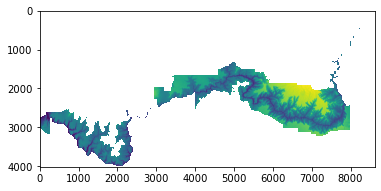

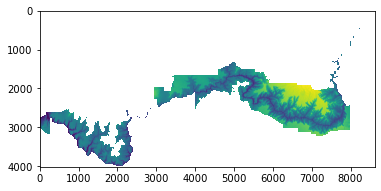

In [ ]:
plt.imshow(demData);  # Visualize a basic plot of the DEM data

#### Next, add some additional parameters to the plot.

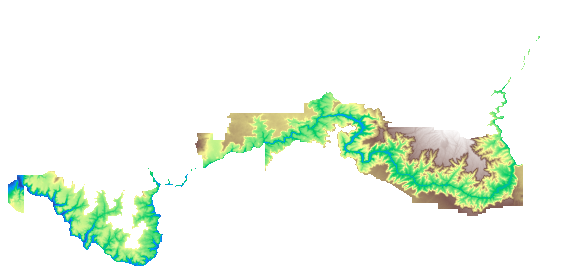

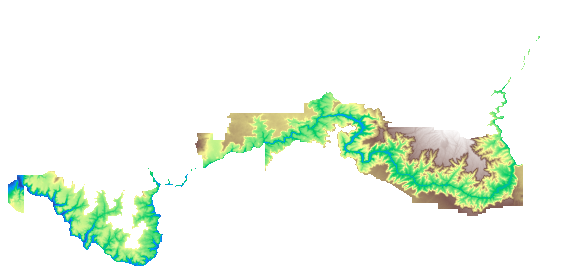

In [ ]:
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize = (10,7.5))  # Set the figure size (x,y)
plt.axis('off')                       # Remove the axes' values
ax = fig.add_subplot(111)             

# Plot the array, using a colormap and setting a custom linear stretch based on the min/max Elevation values
plt.imshow(demData, vmin = np.nanmin(demData), vmax = np.nanmax(demData), cmap = 'terrain');

#### Finally, add important map items including a legend and title.

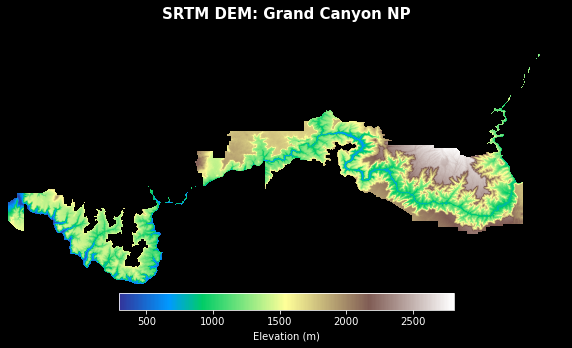

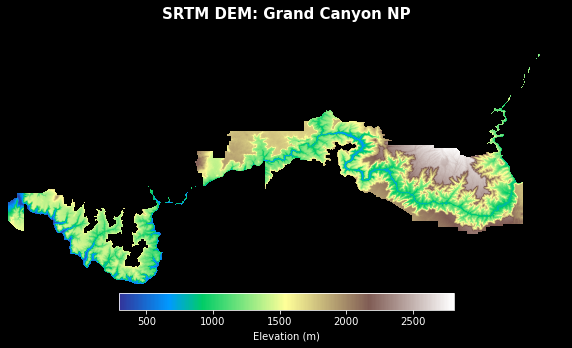

In [ ]:
plt.style.use("dark_background")                                                       # Default to a black background
fig2 = plt.figure(figsize=(10,7.5))                                                    # Set the figure size
plt.axis('off')                                                                        # Remove the axes' values
ax1 = fig2.add_subplot(111)                                                            # Make a subplot
fig2.subplots_adjust(top=3.8)                                                          # Adjust spacing
ax1.set_title('SRTM DEM: Grand Canyon NP',fontsize=15,fontweight='bold',color='white') # Add title

# Plot the masked data, using a colormap and setting a custom linear stretch based on the min/max DEM values
im = plt.imshow(demData, vmin = np.nanmin(demData), vmax = np.nanmax(demData), cmap = 'terrain');

cb = plt.colorbar(im, orientation='horizontal', fraction=0.047, pad=0.004, shrink=0.6) # Add a colormap legend
cb.set_label(label='Elevation (m)', color = 'white')                                   # Set Label and color
cb.outline.set_edgecolor('white')                                                      # Set edge color

### This example can provide a template to use for your own research workflows. Leveraging the AρρEEARS API for searching, extracting, and formatting analysis ready data, and importing it directly into Python means that you can keep your entire research workflow in a single software program, from start to finish. 

***
<div class="alert alert-block alert-info">
<h1> Contact Information </h1>   
    
<h3> Material written by LP DAAC$^{1}$ </h3>  

<b>Contact:</b> LPDAAC@usgs.gov    

<b>Voice:</b> +1-605-594-6116    

<b>Organization:</b> Land Processes Distributed Active Archive Center (LP DAAC)  

<b>Website:</b> https://lpdaac.usgs.gov/  

<b>Date last modified:</b> 05-06-2022    

$^{1}$Innovate! Inc., contractor to the U.S. Geological Survey, Earth Resources Observation and Science (EROS) Center, Sioux Falls, South Dakota, 57198-001, USA. Work performed under USGS contract G15PD00467 for LP DAAC$^{2}$.

$^{2}$LP DAAC Work performed under NASA contract NNG14HH33I. 